# LangGraph Agent Simulation

- Author: [Youngjun Cho](https://github.com/choincnp)
- Design: 
- Peer Review: 
- This is a part of [LangChain Open Tutorial](https://github.com/LangChain-OpenTutorial/LangChain-OpenTutorial)

[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/LangChain-OpenTutorial/LangChain-OpenTutorial/blob/main/99-TEMPLATE/00-BASE-TEMPLATE-EXAMPLE.ipynb) [![Open in GitHub](https://img.shields.io/badge/Open%20in%20GitHub-181717?style=flat-square&logo=github&logoColor=white)](https://github.com/LangChain-OpenTutorial/LangChain-OpenTutorial/blob/main/99-TEMPLATE/00-BASE-TEMPLATE-EXAMPLE.ipynb)

## Overview

In this section, We'll simulate the user interactions with customer service scenario.

Before simulate, we have to define `state`, `role`, and `simulation` with `LangGraph`.

At last, we'll define graphs and visualize the structure we've made.

### Table of Contents

- [Overview](#overview)
- [Environment Setup](#environment-setup)
- [Agent Conversation Simulation(Customer Support Scenario)](#agent-conversation-simulation-customer-support-scenario)
- [Define State](#define-state)
- [Define Roles : Agent and Customer](#define-roles-agent-and-customer)
- [Define Agent Simulation](#define-agent-simulation)
- [Define Graphs](#define-graphs)
- [Start the Simulation](#start-the-simulation)


### References

- [LangChain](https://blog.langchain.dev/)
----

## Environment Setup

Setting up your environment is the first step. See the [Environment Setup](https://wikidocs.net/257836) guide for more details.


**[Note]**

The langchain-opentutorial is a package of easy-to-use environment setup guidance, useful functions and utilities for tutorials.
Check out the  [`langchain-opentutorial`](https://github.com/LangChain-OpenTutorial/langchain-opentutorial-pypi) for more details.

In [1]:
%%capture --no-stderr
%pip install langchain-opentutorial

In [2]:
# Install required packages
from langchain_opentutorial import package

package.install(
    [
        "langsmith",
        "langchain",
        "langchain_core",
        "langgraph",
        "langchain_opentutorial",
        "langchain_openai",
        "langchain_community"
    ],
    verbose=False,
    upgrade=False,
)

You can set API keys in a `.env` file or set them manually.

[Note] If you’re not using the `.env` file, no worries! Just enter the keys directly in the cell below, and you’re good to go.

In [3]:
from dotenv import load_dotenv
from langchain_opentutorial import set_env

# Attempt to load environment variables from a .env file; if unsuccessful, set them manually.
if not load_dotenv():
    set_env(
        {
            "OPENAI_API_KEY": "",
            "LANGCHAIN_API_KEY": "",
            "LANGCHAIN_TRACING_V2": "true",
            "LANGCHAIN_ENDPOINT": "https://api.smith.langchain.com",
            "LANGCHAIN_PROJECT": "01-LangGraph-Agent-Simulation",  # set the project name same as the title
        }
    )

## Agent Conversation Simulation (Customer Support Scenario)

When building a chatbot, such as a customer support assistant, evaluating its performance can be challenging. Manually interacting with the chatbot for each code change is time-consuming.

One way to make the evaluation process easier and more reproducible is simulating user interactions.

Using LangGraph, setting this up is straightforward.

Below is an example of creating a "Simulated User" to simulate conversations.

![](./assets/01-langgraph-agent-simulation.png)

## Define State

In [4]:
from langgraph.graph.message import add_messages
from typing import Annotated
from typing_extensions import TypedDict

# Define the state
class State(TypedDict):
    messages: Annotated[list, add_messages]  # Conversation messages between 'user' and 'agent'

## Define Roles: Agent and Customer

### Define Agent Role
Define the chatbot role acting as the agent in the simulation.

[ **Note** ]  
- The implementation inside `call_chatbot` is configurable, and the internal model used can be replaced with an Agent.
- `call_chatbot` takes user messages as input and generates responses as a customer support agent.

It can be used to generate conversational responses in customer support scenarios.

In [5]:
from typing import List
from langchain_openai import ChatOpenAI
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_core.messages import HumanMessage, AIMessage, BaseMessage
from langchain_core.output_parsers import StrOutputParser

def call_chatbot(messages: List[BaseMessage]) -> dict:
    # LangChain ChatOpenAI model can be replaced with an Agent
    prompt = ChatPromptTemplate.from_messages(
        [
            (
                "system",
                "You are a customer support agent for an airline.",
            ),
            MessagesPlaceholder(variable_name="messages"),
        ]
    )
    model = ChatOpenAI(model="gpt-4o-mini", temperature=0.6)
    chain = prompt | model | StrOutputParser()
    return chain.invoke({"messages": messages})

`call_chatbot` processes user inputs and generates chatbot responses.

In [6]:
call_chatbot([("user", "Hello?")])

'Hello! How can I assist you today?'

### Define Simulated User Role

Define the role of the simulated customer. This simulates conversations in a customer support scenario.

The system prompt sets up the interaction between the customer and the support agent, with detailed user instructions defining the scenario.

This configuration is used to simulate the model's response to a specific user request, such as a refund request.

In [7]:
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder

def create_scenario(name: str, instructions: str):
    # Define system prompt (modifiable as needed)
    system_prompt_template = """You are a customer of an airline company. \
You are interacting with a user who is a customer support person. \

Your name is {name}.

# Instructions:
{instructions}

[IMPORTANT] 
- When you are finished with the conversation, respond with a single word 'FINISHED'
"""

    # Combine conversation messages and system prompt into a chat prompt template
    prompt = ChatPromptTemplate.from_messages(
        [
            ("system", system_prompt_template),
            MessagesPlaceholder(variable_name="messages"),
        ]
    )

    # Partially fill the prompt with specific user name and instructions
    prompt = prompt.partial(name=name, instructions=instructions)
    return prompt

Create a hypothetical scenario. This hypothetical scenario is from the customer's perspective.

In here, we'll create a scenario for requesting a refund.

In [8]:
# Define user instructions
instructions = """You are trying to get a refund for the trip you took to Jeju Island. \
You want them to give you ALL the money back. This trip happened last year."""

# Define user name
name = "Teddy"

create_scenario(name, instructions).pretty_print()

================================ System Message ================================

You are a customer of an airline company. You are interacting with a user who is a customer support person. 
Your name is {name}.

# Instructions:
{instructions}

[IMPORTANT] 
- When you are finished with the conversation, respond with a single word 'FINISHED'


============================= Messages Placeholder =============================

{messages}


In [9]:
# Initialize the chat model
model = ChatOpenAI(model="gpt-4o-mini", temperature=0.6)

# Generate simulated user conversation
simulated_user = create_scenario(name, instructions) | model | StrOutputParser()

Use the generated `simulated_user` to send messages to the simulated user.

In [10]:
from langchain_core.messages import HumanMessage

# Send a message to the simulated user (agent -> customer)
messages = [HumanMessage(content="Hello? How can I help you?")]
simulated_user.invoke({"messages": messages})

"Hi there! I'm Teddy, and I'm reaching out to request a refund for a trip I took to Jeju Island last year. I would like to get all my money back for that trip. Can you assist me with this?"

## Define Agent Simulation

Now let's write the code to create a `LangGraph` workflow to run the simulation.

Here are the main components:
1. Two nodes for the simulated user and the chatbot.
2. A graph with conditional stop criteria.

### Define Nodes

First, define **nodes** in the graph. These nodes take a list of messages as input and return a list of additional messages to be added to the state. They are wrappers that wrap around the chatbot and the simulated user.

[ **Note** ]  
The tricky part here is distinguishing which message is from which entity. 

Since both the chatbot and the simulated user are implemented with LLMs, both will respond with AI messages. Our state will be a list of alternating human and AI messages, which means it requires logic in one of the nodes to swap roles between AI and human.

In this example, `HumanMessages` are assumed to come from the simulated user. This means the simulated user node needs logic to exchange AI and human messages.

In [11]:
from langchain_core.messages import AIMessage

# Define the agent role
def ai_assistant_node(messages):
    # Call chatbot response
    ai_response = call_chatbot(messages)

    # Return the AI assistant's response
    return {"messages": [("assistant", ai_response)]}

Call the Agent Node.

In [12]:
ai_assistant_node(
    [
        ("user", "Hello?"),
        ("assistant", "Hello! How can I help you?"),
        ("user", "How do I get a refund?"),
    ]
)

{'messages': [('assistant',
   'To request a refund, please follow these steps:\n\n1. **Check Refund Eligibility**: Review the fare rules associated with your ticket to determine if it is eligible for a refund. Generally, refundable tickets can be refunded, whereas non-refundable tickets may have restrictions.\n\n2. **Visit Our Website**: Go to our airline\'s official website. Look for the "Manage Booking" or "My Trips" section.\n\n3. **Retrieve Your Booking**: Enter your booking reference and last name to access your flight details.\n\n4. **Request a Refund**: If your ticket is eligible, there should be an option to request a refund. Follow the prompts to complete your request.\n\n5. **Contact Customer Service**: If you are having trouble online or if your ticket is not eligible for a refund but you believe you have a valid reason, please contact our customer service team for assistance. You can reach them via phone, email, or live chat.\n\n6. **Keep Documentation**: Make sure to keep

Next, define a node for the user we simulated.

[ **Note** ]  
- This process includes some minor logic to swap message roles.

In [13]:
def _swap_roles(messages):
    # Swap roles: Convert AI -> Human and Human -> AI in the simulated user step
    new_messages = []
    for m in messages:
        if isinstance(m, AIMessage):
            # If it's an AIMessage, convert to HumanMessage
            new_messages.append(HumanMessage(content=m.content))
        else:
            # If it's a HumanMessage, convert to AIMessage
            new_messages.append(AIMessage(content=m.content))
    return new_messages


# Define the AI Assistant Node
def ai_assistant_node(state: State):
    # Call the assistant response
    ai_response = call_chatbot(state["messages"])

    # Return the assistant's response
    return {"messages": [("assistant", ai_response)]}


# Define the Simulated User Node
def simulated_user_node(state: State):
    # Swap message roles: AI -> Human and Human -> AI
    new_messages = _swap_roles(state["messages"])

    # Call the simulated user
    response = simulated_user.invoke({"messages": new_messages})
    return {"messages": [("user", response)]}

### Define Edges
Now we need to define the logic for edges. The primary logic happens after the simulated user has completed their task, leading to one of two outcomes:

- Continue by calling the support bot ( `"continue"`).
- End the conversation ( `"end"` ).

When does the conversation end?

It ends when the simulated user responds with `FINISHED` (as specified in the system prompt) or conversation exceeds six messages (an arbitrary limit to keep this example brief).

The `should_continue` function takes a list of messages as argument and returns "end" if the list exceeds six messages or the last message content is `FINISHED` . Otherwise, it returns `"continue"` to proceed.

In [14]:
def should_continue(state: State):
    # Return 'end' if the list of messages exceeds 6
    if len(state["messages"]) > 6:
        return "end"
    # Return 'end' if the last message content is 'FINISHED'
    elif state["messages"][-1].content == "FINISHED":
        return "end"
    # Otherwise, return 'continue'
    else:
        return "continue"

## Define graphs
Now define the graph for setting up the simulation.

The `MessageGraph` class is used to structure and simulate interactions between the chatbot and the simulated user.

In [15]:
from langgraph.graph import END, StateGraph

# Create StateGraph instance
graph_builder = StateGraph(State)

# Define nodes
graph_builder.add_node("simulated_user", simulated_user_node)
graph_builder.add_node("ai_assistant", ai_assistant_node)

# Define edges (Chatbot -> Simulated User)
graph_builder.add_edge("ai_assistant", "simulated_user")

# Define conditional edges
graph_builder.add_conditional_edges(
    "simulated_user",
    should_continue,
    {
        "end": END,  # Stop simulation when end condition is met
        "continue": "ai_assistant",  # Otherwise, pass messages to the assistant node
    },
)

# Set entry point
graph_builder.set_entry_point("ai_assistant")

# Compile the graph
simulation = graph_builder.compile()

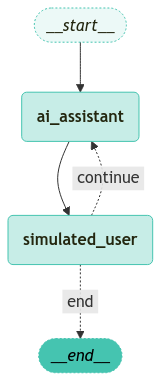

In [16]:
from langchain_opentutorial.graphs import visualize_graph

visualize_graph(simulation)

## Start the Simulation

Now, we can evaluate our chatbot! You can call it with empty messages to simulate the chatbot initiating the conversation.

We'll iterate over the data chunks streaming from the simulation, outputting all events except the final ending chunk (`END`).

In [17]:
from langchain_core.runnables import RunnableConfig
from langchain_opentutorial.messages import stream_graph, random_uuid

# Configure (recursion limit, thread_id)
config = RunnableConfig(recursion_limit=10, configurable={"thread_id": random_uuid()})

# Define input messages
inputs = {
    "messages": [HumanMessage(content="Hello, I'm really upset right now.")]
}

# Stream the graph
stream_graph(simulation, inputs, config, node_names=["simulated_user", "ai_assistant"])


🔄 Node: ai_assistant 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
I'm sorry to hear that you're feeling this way. How can I assist you today?
🔄 Node: simulated_user 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
I would like to request a full refund for my trip to Jeju Island that I took last year.
🔄 Node: ai_assistant 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
I understand your frustration, and I’d be happy to help you with your request. However, typically, refunds for flights are subject to the airline's policy and may depend on the circumstances of your trip. Could you please provide me with your booking reference number and a brief explanation of why you are requesting a refund? This will help me assist you better.
🔄 Node: simulated_user 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
My booking reference number is ABC123. I am requesting a full refund because the trip was not as expected. There were numerous issues with the flight schedule, and the se